### Importing Libraries


In [ ]:
# Import basic libraries
import numpy as np  # For working with arrays and numerical data
import pandas as pd  # For handling tabular data

# For loading and processing images
from PIL import Image

# For plotting images and graphs
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch libraries for datasets and data loading
from torch.utils.data import Dataset, DataLoader

# PyTorch image transformations (resize, normalize, etc.)
import torchvision.transforms as transforms

# PyTorch core and neural network modules
import torch
import torch.nn as nn
import torch.optim as optim

# Pretrained ResNet models
from torchvision.models import resnet18, resnet34, resnet50

# For splitting data into train and test sets and for confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# For evaluating model performance
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# For balancing classes if needed
from sklearn.utils import resample

# For file handling
import os
import glob  # For finding files with specific patterns

# For handling date and time
from datetime import datetime

In [ ]:
# Load training labels from CSV file
train = pd.read_csv(
    "src/task1/train_labels.csv")

# Load test image IDs from CSV file
test = pd.read_csv(
    "src/task1/test_ids.csv")

# Define directory paths for train and test images
train_dir = "src/task1/train"
test_dir = "src/task1/test"

# Print the first few rows of the training and test dataframes to check the contents
print(train.head())
print(test.head())

In [ ]:
# # Load training labels from CSV file
# train = pd.read_csv(
#     "/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv")

# # Load test image IDs from CSV file
# test = pd.read_csv(
#     "/kaggle/input/soil-classification/soil_classification-2025/test_ids.csv")

# # Define directory paths for train and test images
# train_dir = "/kaggle/input/soil-classification/soil_classification-2025/train"
# test_dir = "/kaggle/input/soil-classification/soil_classification-2025/test"

# # Print the first few rows of the training and test dataframes to check the contents
# print(train.head())
# print(test.head())

           image_id      soil_type
0  img_ed005410.jpg  Alluvial soil
1  img_0c5ecd2a.jpg  Alluvial soil
2  img_ed713bb5.jpg  Alluvial soil
3  img_12c58874.jpg  Alluvial soil
4  img_eff357af.jpg  Alluvial soil
            image_id
0  img_cdf80d6f.jpeg
1   img_c0142a80.jpg
2   img_91168fb0.jpg
3   img_9822190f.jpg
4  img_e5fc436c.jpeg


### Preprocessing the Image Data and Loading Train/Test Data


In [ ]:
# Create a dictionary mapping image_id to soil_type
soil_type_dict = dict(zip(train['image_id'], train['soil_type']))

# List to store image data and labels
train_data_list = []

# Loop through each image ID in the training data
for image_id in train['image_id']:
    # Create full path to the image file
    image_path = os.path.join(train_dir, image_id)

    # Check if the image file exists
    if os.path.exists(image_path):
        # Open the image and convert it to RGB format
        image = Image.open(image_path).convert("RGB")

        # Get the corresponding soil type label
        soil_type = soil_type_dict[image_id]

        # Add image ID, image data, and label to the list
        train_data_list.append({
            'image_id': image_id,
            'image_data': image,
            'soil_type': soil_type
        })

# Convert the list to a DataFrame for easier handling
train_data = pd.DataFrame(train_data_list)

# Display the first few rows of the processed training data
print(train_data.head())

           image_id                                         image_data  \
0  img_ed005410.jpg  <PIL.Image.Image image mode=RGB size=728x728 a...   
1  img_0c5ecd2a.jpg  <PIL.Image.Image image mode=RGB size=1160x522 ...   
2  img_ed713bb5.jpg  <PIL.Image.Image image mode=RGB size=1160x522 ...   
3  img_12c58874.jpg  <PIL.Image.Image image mode=RGB size=1160x522 ...   
4  img_eff357af.jpg  <PIL.Image.Image image mode=RGB size=1160x522 ...   

       soil_type  
0  Alluvial soil  
1  Alluvial soil  
2  Alluvial soil  
3  Alluvial soil  
4  Alluvial soil  


In [ ]:
# Initialize an empty DataFrame for test data
test_data = pd.DataFrame()

# Dictionary to store test images by their filenames
test_data_dict = {}

# Walk through the test directory to find image files
for dirname, _, filenames in os.walk(test_dir):
    for filename in filenames:
        # Build the full path to the image file
        image_path = os.path.join(dirname, filename)

        # Open the image and convert it to RGB format
        image = Image.open(image_path).convert("RGB")

        # Store the image in the dictionary with filename as the key
        test_data_dict[filename] = image

# Create a list to store matched test images with their IDs
test_data_list = []

# Loop through the test image IDs from the CSV file
for image_id in test['image_id']:
    # If the image exists in the dictionary, add it to the list
    if image_id in test_data_dict:
        test_data_list.append({
            'image_id': image_id,
            'image_data': test_data_dict[image_id]
        })

# Convert the list into a DataFrame
test_data = pd.DataFrame(test_data_list)

# Show the first few rows of the test data
print(test_data.head())

            image_id                                         image_data
0  img_cdf80d6f.jpeg  <PIL.Image.Image image mode=RGB size=319x158 a...
1   img_c0142a80.jpg  <PIL.Image.Image image mode=RGB size=1500x1125...
2   img_91168fb0.jpg  <PIL.Image.Image image mode=RGB size=462x280 a...
3   img_9822190f.jpg  <PIL.Image.Image image mode=RGB size=1500x1101...
4  img_e5fc436c.jpeg  <PIL.Image.Image image mode=RGB size=100x100 a...


### Converting Soil Types into Integers


In [ ]:
# Get the unique soil type labels from the training data
unique_soil_types = train_data['soil_type'].unique()

In [ ]:
# Create a mapping from soil type (string) to a unique integer label
soil_type_mapping = {soil: idx for idx, soil in enumerate(unique_soil_types)}

# Print the mapping to see which soil type corresponds to which label
print(soil_type_mapping)

# Replace the soil type strings in the training data with their corresponding integer labels
train_data['soil_type'] = train_data['soil_type'].map(soil_type_mapping)

{'Alluvial soil': 0, 'Clay soil': 1, 'Red soil': 2, 'Black Soil': 3}


### Visualizing the train data


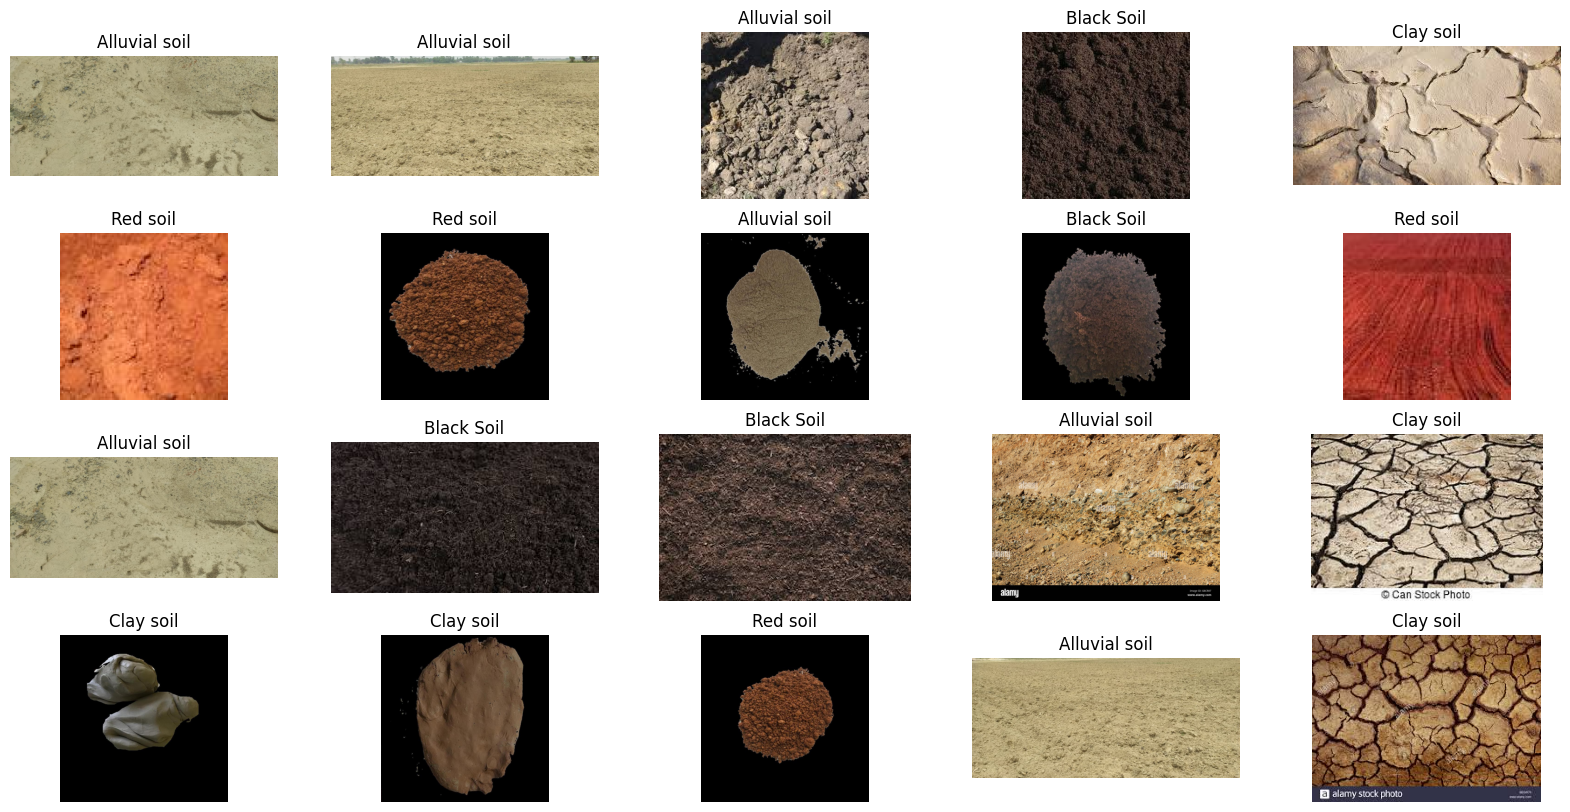

In [ ]:
# Function to visualize random images from the dataset
def visualize_data(data, num_images=20, seed=42):
    # Set a random seed for reproducibility
    np.random.seed(seed)

    # Randomly choose indices from the dataset
    idxs = np.random.choice(len(data), size=num_images, replace=False)

    # Set the figure size for plotting
    plt.figure(figsize=(20, 10))

    # Loop over selected indices and plot each image with its label
    for i, idx in enumerate(idxs):
        plt.subplot(4, 5, i + 1)  # 4 rows and 5 columns
        plt.imshow(data['image_data'].iloc[idx])  # Show image

        # Get the label index and convert it back to the label name
        label_idx = data['soil_type'].iloc[idx]
        label_name = [k for k, v in soil_type_mapping.items()
                      if v == label_idx][0]

        plt.title(label_name)  # Set the title as soil type
        plt.axis('off')  # Hide axes

    # Display the full plot
    plt.show()


# Call the function to visualize 20 random training images
visualize_data(train_data, num_images=20)

In [ ]:
# print train and test data shapes
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1222, 3)
Test data shape: (341, 2)


### SOIL DataSet Class


In [ ]:
# Custom PyTorch Dataset class for soil image classification
class SoilDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data (DataFrame): DataFrame containing image data and labels.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image from the DataFrame
        image = self.data['image_data'].iloc[idx]

        # Get the label if it exists, else use -1 (for test data)
        if 'soil_type' in self.data.columns:
            label = self.data['soil_type'].iloc[idx]
        else:
            label = -1

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        # Return the image and its label
        return image, label

### Checking for Class Imbalance


Alluvial soil: 528
Clay soil: 199
Red soil: 264
Black Soil: 231


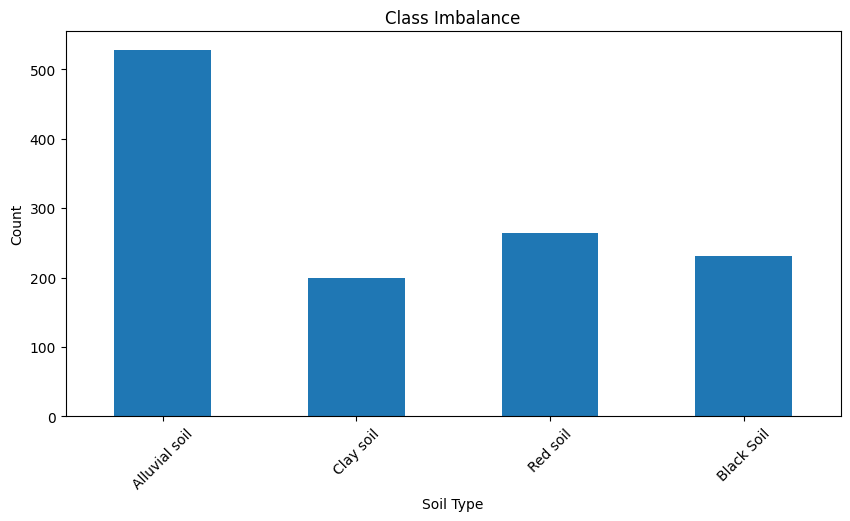

In [ ]:
# Function to check and visualize class imbalance in the dataset
def check_class_imbalance(data):
    # Count the number of samples for each soil type (by integer label)
    class_counts = data['soil_type'].value_counts().sort_index()

    # Print the count of each class with its original soil type name
    for idx, count in class_counts.items():
        soil_name = [k for k, v in soil_type_mapping.items() if v == idx][0]
        print(f"{soil_name}: {count}")

    # Plot the class distribution as a bar chart
    plt.figure(figsize=(10, 5))
    class_counts.plot(kind='bar')
    plt.title('Class Imbalance')
    plt.xlabel('Soil Type')
    plt.ylabel('Count')

    # Set x-axis labels to actual soil type names
    labels = [k for k, v in sorted(
        soil_type_mapping.items(), key=lambda item: item[1])]
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)

    # Show the plot
    plt.show()


# Call the function to visualize class imbalance in the training data
check_class_imbalance(train_data)

### Oversample minority classes to fix class imbalance


Alluvial soil: 528
Clay soil: 528
Red soil: 528
Black Soil: 528


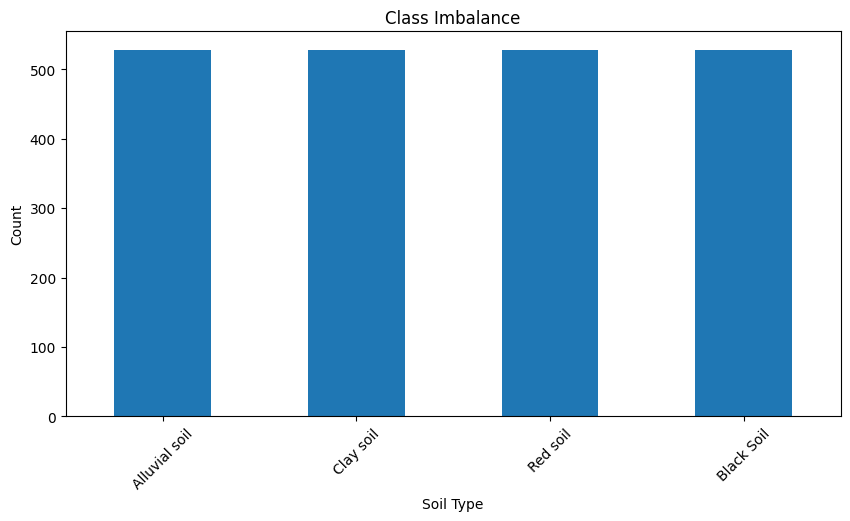

In [ ]:
# Seperate by class
dfs = []
for class_idx in range(len(soil_type_mapping)):
    class_df = train_data[train_data['soil_type'] == class_idx]
    dfs.append(class_df)

# Find the maximum class size
max_size = max([len(df) for df in dfs])

# Resample each class to the max size
dfs_balanced = [
    resample(df, replace=True, n_samples=max_size, random_state=42)
    for df in dfs
]

# Concatenate back into a single DataFrame
train_data_balanced = pd.concat(dfs_balanced).reset_index(drop=True)

# Shuffle the balanced dataset
train_data = train_data_balanced.sample(
    frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
check_class_imbalance(train_data)

### Data Augmentation Pipeline and Dataloaders


In [ ]:
# Define a set of transformations to apply to the images
transform = transforms.Compose([
    # Resize shorter side of image to 256 pixels
    transforms.Resize(256),
    # Random crop to 224x224 with scale variation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    # Randomly flip images horizontally
    transforms.RandomHorizontalFlip(),
    # Randomly change brightness, contrast, saturation, hue
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    # Convert PIL image to PyTorch tensor
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],     # Normalize tensor with ImageNet mean and std
                         std=[0.229, 0.224, 0.225])
])

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split the training data into training and validation sets with stratification by soil type
train_split, val_split = train_test_split(
    train_data, test_size=0.3, stratify=train_data['soil_type'], random_state=42)

# Create PyTorch Dataset and DataLoader for training data
train_dataset = SoilDataset(train_split, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create Dataset and DataLoader for validation data (no shuffle to keep order)
val_dataset = SoilDataset(val_split, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Create Dataset and DataLoader for test data (no shuffle)
test_dataset = SoilDataset(test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Resnet50 Model


In [ ]:
# Load a pre-trained ResNet-50 model
model = resnet50(pretrained=True)

# Replace the final fully connected layer to match the number of soil classes
model.fc = nn.Linear(model.fc.in_features, len(soil_type_mapping))

# Move the model to the chosen device (GPU or CPU)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

### Training Loop


In [ ]:
def calculate_metrics(model, loader):
    model.eval()  # Set model to evaluation mode
    preds, targets = [], []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get class predictions
            preds.extend(predicted.cpu().numpy())  # Collect predictions
            targets.extend(labels.cpu().numpy())   # Collect true labels

    # Calculate precision, recall, f1-score (macro average) and accuracy
    precision, recall, f1, _ = precision_recall_fscore_support(
        targets, preds, average='macro')
    acc = accuracy_score(targets, preds)
    return acc, precision, recall, f1


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    # Create directory to save model checkpoints with timestamp
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    output_dir = os.path.join("checkpoints", timestamp)
    os.makedirs(output_dir, exist_ok=True)

    # Track best validation loss to save best model
    best_val_loss = float('inf')
    # Track best training loss if no validation data
    best_train_loss = float('inf')
    all_metrics = []               # Store metrics for each epoch

    for epoch in range(num_epochs):
        model.train()              # Set model to training mode
        running_loss = 0.0
        train_preds, train_targets = [], []

        # Training loop over batches
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()   # Clear previous gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()         # Backpropagation
            optimizer.step()        # Update model weights

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        # Optionally update learning rate scheduler (commented out here)
        # if scheduler:
        #     scheduler.step()

        # Calculate training metrics for the epoch
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            train_targets, train_preds, average='macro')
        train_acc = accuracy_score(train_targets, train_preds)
        train_loss = running_loss / len(train_loader)

        metrics = {
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'train_precision': train_precision,
            'train_recall': train_recall,
            'train_f1': train_f1,
        }

        if val_loader is not None:
            # Validation phase
            val_loss = 0.0
            model.eval()  # Set to evaluation mode
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            val_acc, val_precision, val_recall, val_f1 = calculate_metrics(
                model, val_loader)

            # Print training and validation results
            print(f"\nEpoch [{epoch+1}/{num_epochs}]")
            print(
                f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}")
            print(
                f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

            # Save best model checkpoint based on validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_path = os.path.join(output_dir, "best_model.pth")
                torch.save(model.state_dict(), best_model_path)
                print(
                    f"✅ Best model saved at epoch {epoch+1} with val loss {best_val_loss:.4f}")

            # Add validation metrics to the metrics dictionary
            metrics.update({
                'val_loss': val_loss,
                'val_accuracy': val_acc,
                'val_precision': val_precision,
                'val_recall': val_recall,
                'val_f1': val_f1,
            })
        else:
            # If no validation loader, only print training results
            print(f"\nEpoch [{epoch+1}/{num_epochs}]")
            print(
                f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}")

            # Save best model based on training loss
            if train_loss < best_train_loss:
                best_train_loss = train_loss
                best_model_path = os.path.join(output_dir, "best_model.pth")
                torch.save(model.state_dict(), best_model_path)
                print(
                    f"✅ Best model saved at epoch {epoch+1} with train loss {best_train_loss:.4f}")

        # Save model at every epoch (can be used for checkpointing)
        torch.save(model.state_dict(), os.path.join(output_dir, "model.pth"))

        # Append metrics of current epoch to list
        all_metrics.append(metrics)

    # Save all metrics collected over epochs to a CSV file
    df_metrics = pd.DataFrame(all_metrics)
    metrics_path = os.path.join(output_dir, "training_metrics.csv")
    df_metrics.to_csv(metrics_path, index=False)
    print(f"📊 Metrics saved to {metrics_path}")

In [ ]:
# Train the model for n epochs
train_model(model, train_loader, val_loader,
            criterion, optimizer, num_epochs=40)


Epoch [1/40]
Train Loss: 0.7804 | Train Acc: 0.7361 | Train F1: 0.7357
Val Loss: 0.8299 | Val Acc: 0.8060 | Val F1: 0.8076
✅ Best model saved at epoch 1 with val loss 0.8299

Epoch [2/40]
Train Loss: 0.5135 | Train Acc: 0.8234 | Train F1: 0.8231
Val Loss: 0.4858 | Val Acc: 0.8486 | Val F1: 0.8500
✅ Best model saved at epoch 2 with val loss 0.4858

Epoch [3/40]
Train Loss: 0.5816 | Train Acc: 0.8038 | Train F1: 0.8028
Val Loss: 0.4012 | Val Acc: 0.8644 | Val F1: 0.8640
✅ Best model saved at epoch 3 with val loss 0.4012

Epoch [4/40]
Train Loss: 0.4887 | Train Acc: 0.8342 | Train F1: 0.8344
Val Loss: 0.3285 | Val Acc: 0.8691 | Val F1: 0.8675
✅ Best model saved at epoch 4 with val loss 0.3285

Epoch [5/40]
Train Loss: 0.4600 | Train Acc: 0.8194 | Train F1: 0.8185
Val Loss: 0.3441 | Val Acc: 0.8927 | Val F1: 0.8926

Epoch [6/40]
Train Loss: 0.4046 | Train Acc: 0.8633 | Train F1: 0.8625
Val Loss: 0.3940 | Val Acc: 0.8517 | Val F1: 0.8545

Epoch [7/40]
Train Loss: 0.4345 | Train Acc: 0.8593

### Visualizing Predictions on Training Set


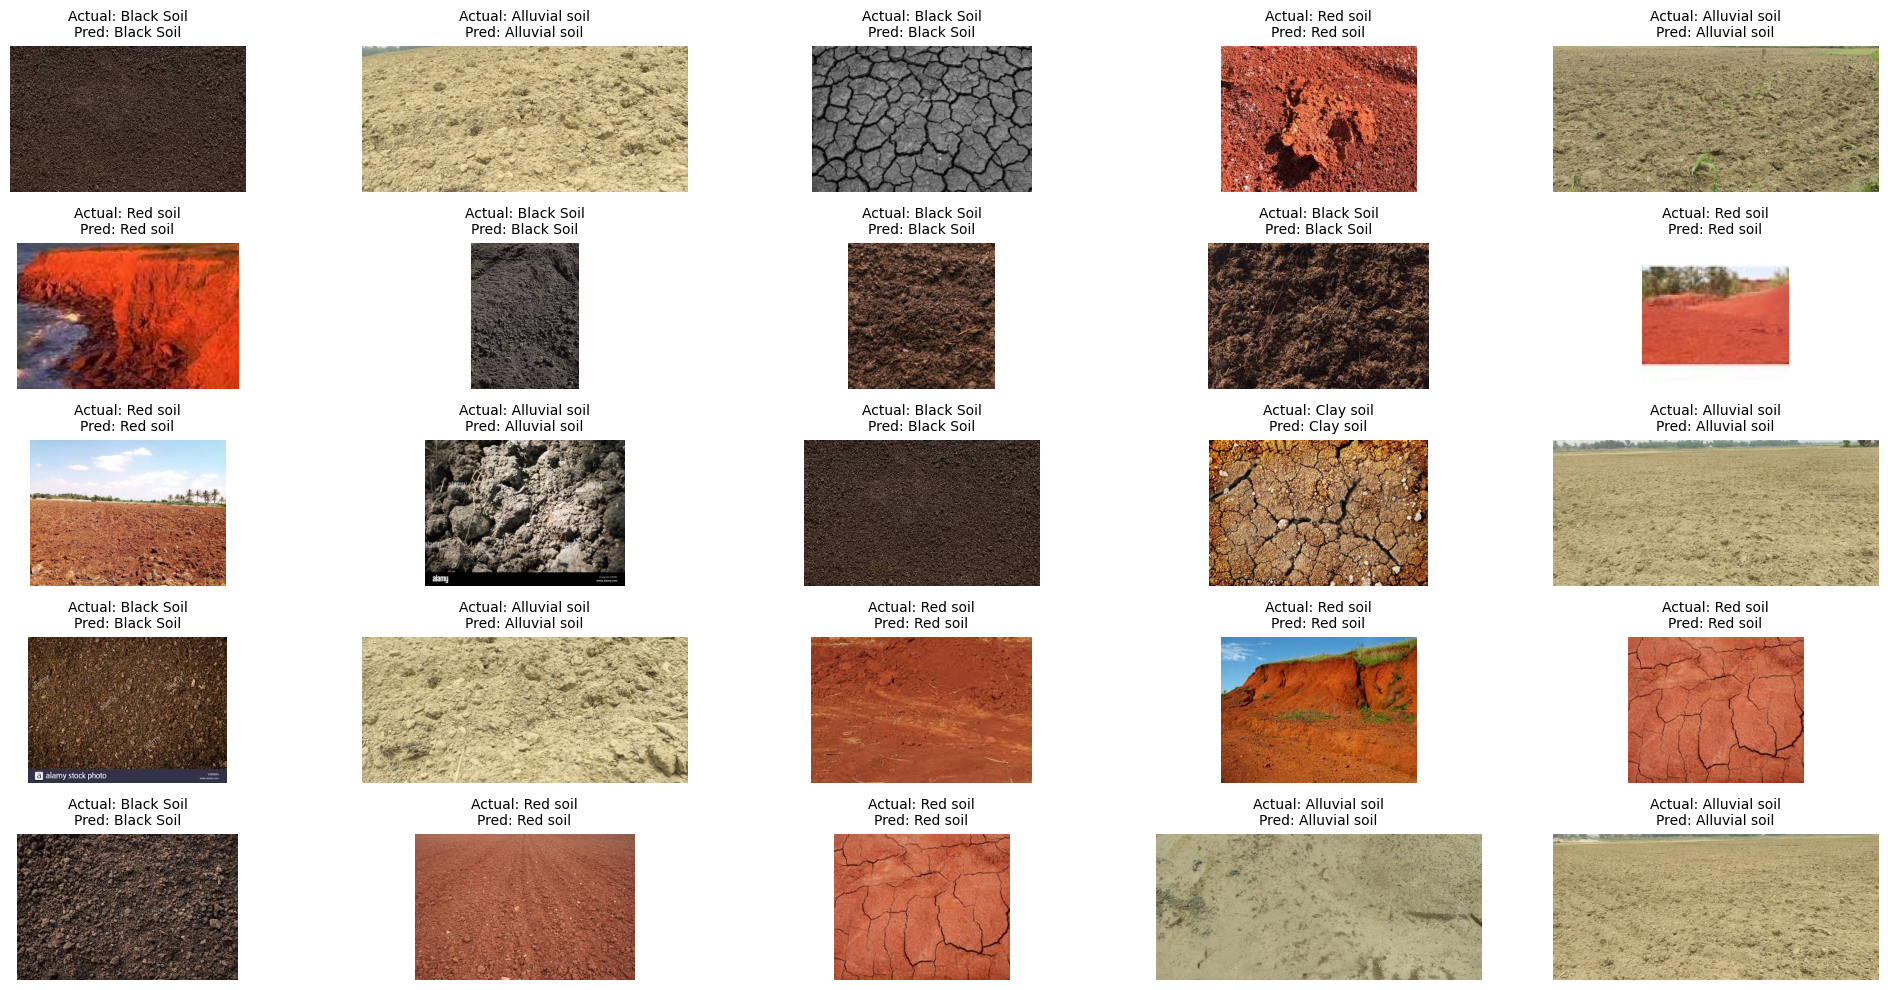

In [ ]:
# Find all checkpoint directories under "checkpoints"
checkpoint_dirs = glob.glob(os.path.join("checkpoints", "*"))

if checkpoint_dirs:
    # Get the most recently modified checkpoint directory
    latest_dir = max(checkpoint_dirs, key=os.path.getmtime)
    best_model_path = os.path.join(latest_dir, "best_model.pth")

    # Load the best model weights if the file exists
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path))
    else:
        print("No best_model.pth found in the latest checkpoint directory.")
else:
    print("No checkpoint directories found.")


def visualize_val_predictions(model, val_loader, num_images=20, seed=42):
    # Set random seed for reproducibility
    np.random.seed(seed)

    # Randomly select indices of images to visualize
    idxs = np.random.choice(len(val_loader.dataset),
                            size=num_images, replace=False)

    plt.figure(figsize=(20, 10))
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for i, idx in enumerate(idxs):
            # Get the image and its true label
            image, actual_label = val_loader.dataset[idx]

            # Prepare image input for the model (add batch dimension and move to device)
            image_input = image.unsqueeze(0).to(device)

            # Get model output and predicted label
            outputs = model(image_input)
            _, predicted = torch.max(outputs, 1)
            predicted_label = predicted.item()

            # Plot the original PIL image from the dataset
            plt.subplot(5, 5, i + 1)
            pil_img = val_loader.dataset.data['image_data'].iloc[idx]
            plt.imshow(pil_img)

            # Map label indices back to soil type names
            actual_name = [k for k, v in soil_type_mapping.items()
                           if v == actual_label][0]
            predicted_name = [
                k for k, v in soil_type_mapping.items() if v == predicted_label][0]

            # Show actual and predicted labels as the title
            plt.title(
                f"Actual: {actual_name}\nPred: {predicted_name}", fontsize=10)
            plt.axis('off')

    plt.tight_layout()
    plt.show()


# Visualize predictions on 25 random images from the training dataset
visualize_val_predictions(model, train_loader, num_images=25)

### Visualizing Predictions on Validation Set


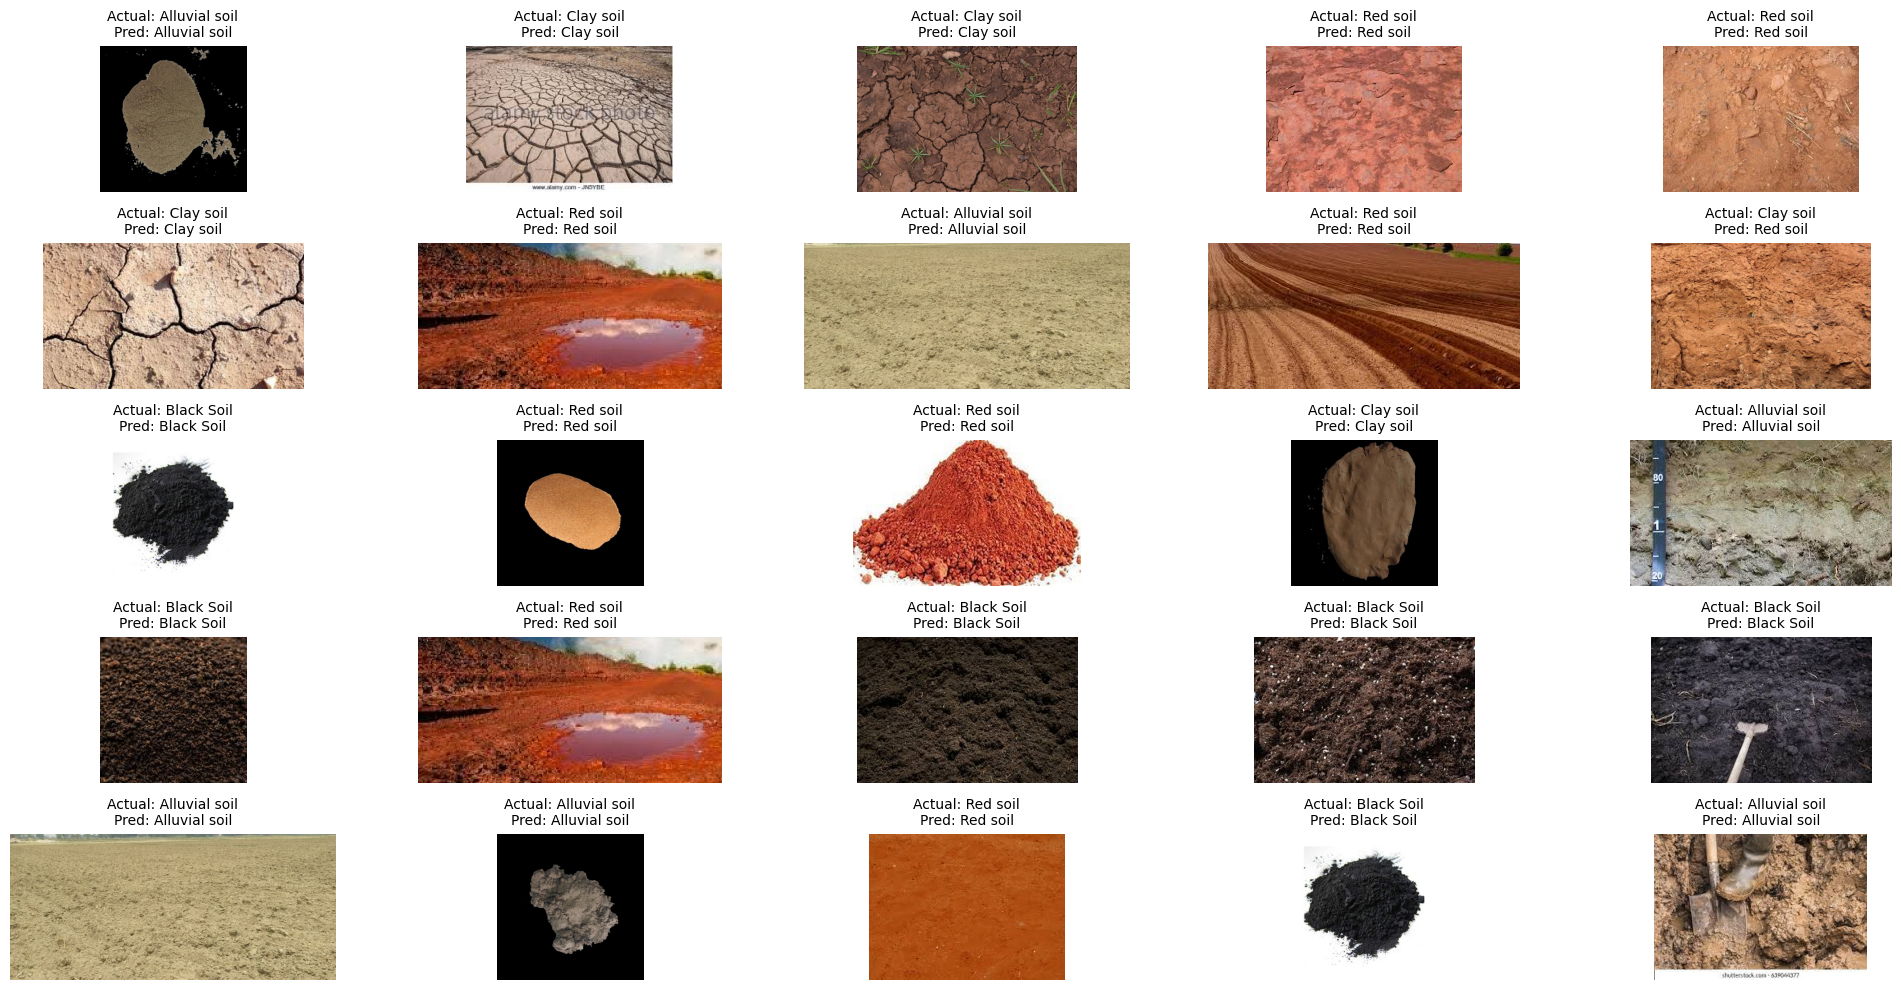

In [ ]:
# Get list of all checkpoint directories in "checkpoints"
checkpoint_dirs = glob.glob(os.path.join("checkpoints", "*"))

if checkpoint_dirs:
    # Find the most recently modified checkpoint directory
    latest_dir = max(checkpoint_dirs, key=os.path.getmtime)
    best_model_path = os.path.join(latest_dir, "best_model.pth")

    # Load the saved best model weights if the file exists
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path))
    else:
        print("No best_model.pth found in the latest checkpoint directory.")
else:
    print("No checkpoint directories found.")


def visualize_val_predictions(model, val_loader, num_images=20, seed=42):
    # Set random seed for reproducibility of random selection
    np.random.seed(seed)

    # Randomly select indices of images to show
    idxs = np.random.choice(len(val_loader.dataset),
                            size=num_images, replace=False)

    plt.figure(figsize=(20, 10))
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient calculation for inference
        for i, idx in enumerate(idxs):
            # Get image and true label from validation dataset
            image, actual_label = val_loader.dataset[idx]

            # Add batch dimension and send image to device (GPU or CPU)
            image_input = image.unsqueeze(0).to(device)

            # Get model output and prediction
            outputs = model(image_input)
            _, predicted = torch.max(outputs, 1)
            predicted_label = predicted.item()

            # Plot the original image from the dataset (PIL image)
            plt.subplot(5, 5, i + 1)
            pil_img = val_loader.dataset.data['image_data'].iloc[idx]
            plt.imshow(pil_img)

            # Map label indices to soil type names
            actual_name = [k for k, v in soil_type_mapping.items()
                           if v == actual_label][0]
            predicted_name = [
                k for k, v in soil_type_mapping.items() if v == predicted_label][0]

            # Show actual and predicted labels as the title
            plt.title(
                f"Actual: {actual_name}\nPred: {predicted_name}", fontsize=10)
            plt.axis('off')  # Hide axes for clarity

    plt.tight_layout()
    plt.show()


# Visualize predictions on 25 random images from the validation dataset
visualize_val_predictions(model, val_loader, num_images=25)

### VIsualizing Predictions on Test Set


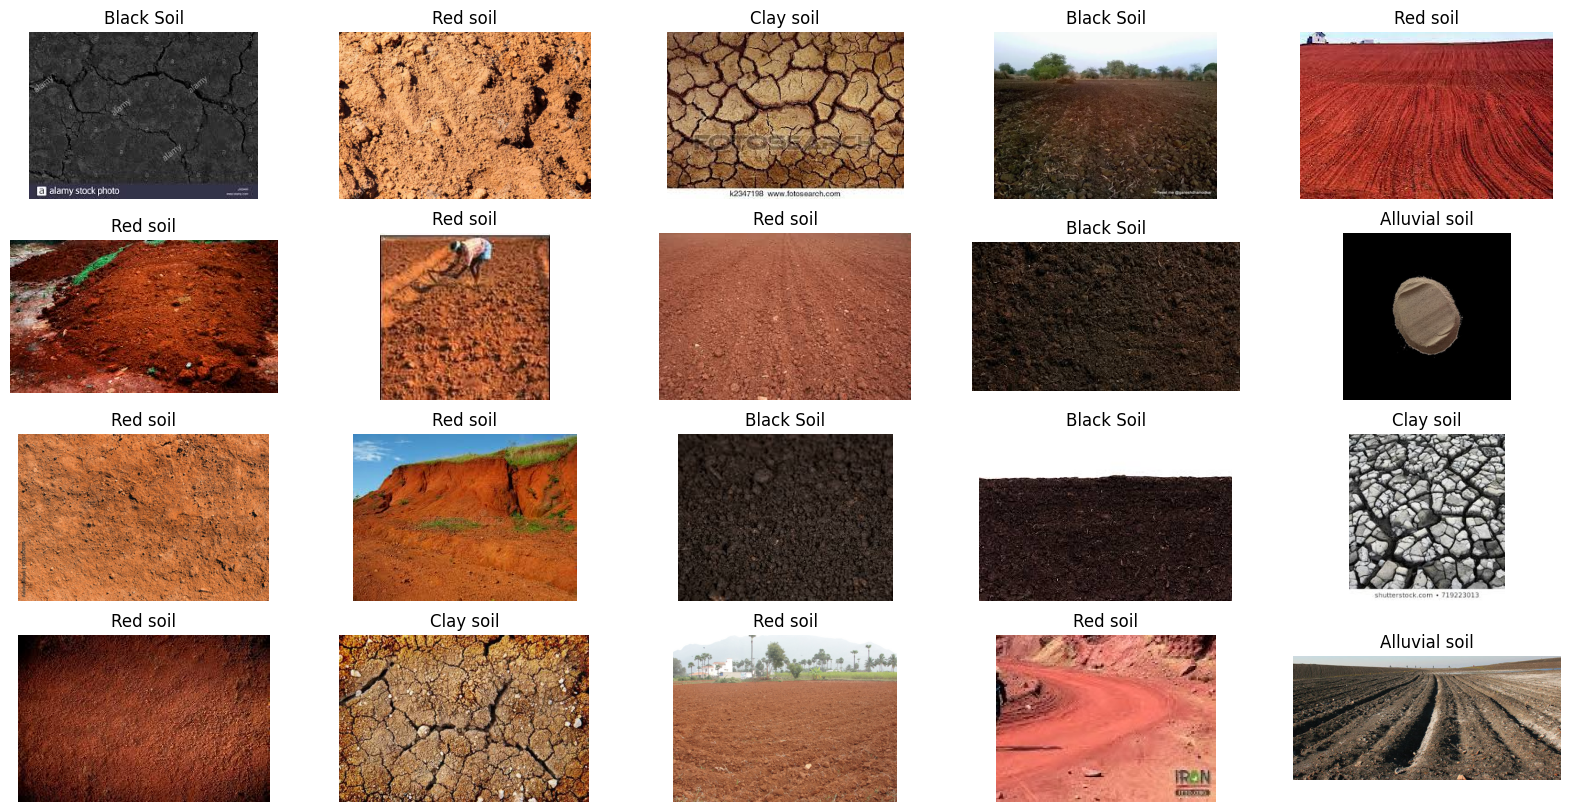

In [ ]:
# Find all checkpoint directories
checkpoint_dirs = glob.glob(os.path.join("checkpoints", "*"))

if checkpoint_dirs:
    # Get the most recent checkpoint directory
    latest_dir = max(checkpoint_dirs, key=os.path.getmtime)
    best_model_path = os.path.join(latest_dir, "best_model.pth")

    # Load the best model if it exists
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path))
    else:
        print("No best_model.pth found in the latest checkpoint directory.")
else:
    print("No checkpoint directories found.")


def visualize_predictions(model, test_loader, num_images=20, seed=42):
    # Set seed for reproducibility of random picks
    np.random.seed(seed)

    # Randomly select indices of images to display
    idxs = np.random.choice(len(test_loader.dataset),
                            size=num_images, replace=False)

    plt.figure(figsize=(20, 10))
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient calculation
        for i, idx in enumerate(idxs):
            # Get the image (ignore label)
            images, _ = test_loader.dataset[idx]

            # Add batch dimension and send to device
            images = images.unsqueeze(0).to(device)

            # Get model prediction
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predicted_label = predicted.item()

            # Plot image from original dataset (PIL)
            plt.subplot(4, 5, i + 1)
            plt.imshow(test_loader.dataset.data['image_data'].iloc[idx])

            # Get predicted label name
            label_name = [k for k, v in soil_type_mapping.items()
                          if v == predicted_label][0]

            # Set title to predicted label
            plt.title(label_name)
            plt.axis('off')  # Hide axes for cleaner look

    plt.show()


# Visualize predictions on 20 random test images
visualize_predictions(model, test_loader, num_images=20)

### Confusion Matrix


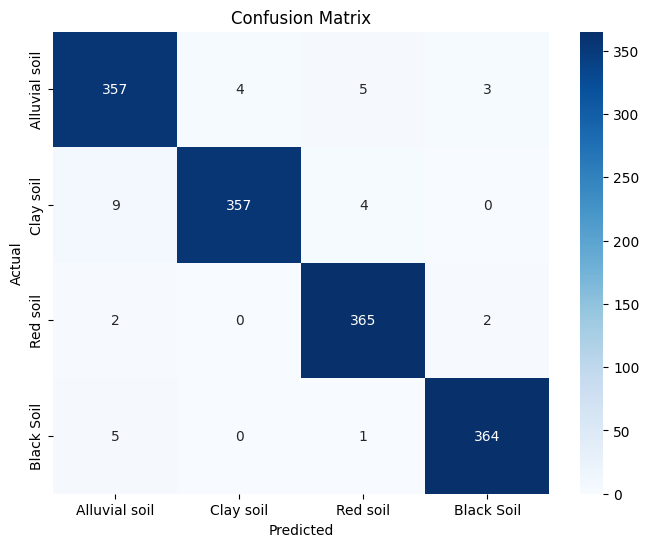

Classification Report:

               precision    recall  f1-score   support

Alluvial soil      0.957     0.967     0.962       369
    Clay soil      0.989     0.965     0.977       370
     Red soil      0.973     0.989     0.981       369
   Black Soil      0.986     0.984     0.985       370

     accuracy                          0.976      1478
    macro avg      0.976     0.976     0.976      1478
 weighted avg      0.976     0.976     0.976      1478



In [ ]:
# Set model to evaluation mode
model.eval()

# Lists to store all predictions and true labels
all_preds = []
all_labels = []

# Disable gradient calculations for inference
with torch.no_grad():
    # Iterate through the training data loader
    for images, labels in train_loader:
        images = images.to(device)  # Move images to device (CPU/GPU)
        labels = labels.to(device)  # Move labels to device

        outputs = model(images)  # Forward pass
        _, preds = torch.max(outputs, 1)  # Get predicted class indices

        # Collect predictions and true labels (moving back to CPU and numpy)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Get class names sorted by their label index
class_names = [k for k, v in sorted(
    soil_type_mapping.items(), key=lambda item: item[1])]

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generate and print classification report with precision, recall, f1-score
report = classification_report(
    all_labels, all_preds, target_names=class_names, digits=3)
print("Classification Report:\n")
print(report)

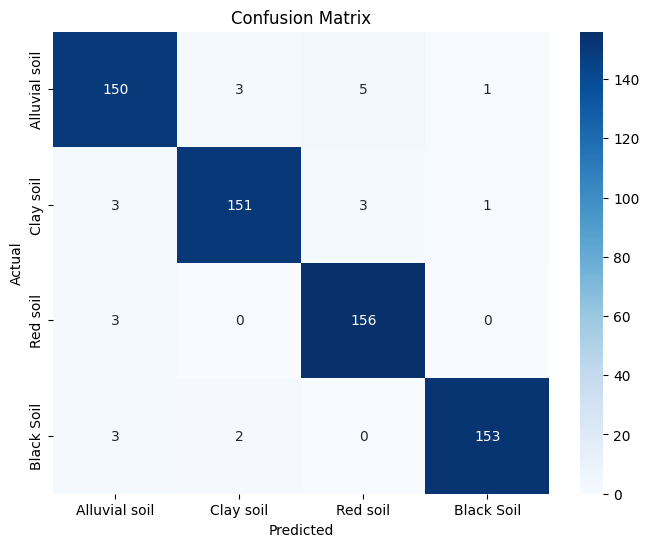

Classification Report:

               precision    recall  f1-score   support

Alluvial soil      0.943     0.943     0.943       159
    Clay soil      0.968     0.956     0.962       158
     Red soil      0.951     0.981     0.966       159
   Black Soil      0.987     0.968     0.978       158

     accuracy                          0.962       634
    macro avg      0.962     0.962     0.962       634
 weighted avg      0.962     0.962     0.962       634



In [ ]:
# Get predictions and true labels for the validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = [k for k, v in sorted(
    soil_type_mapping.items(), key=lambda item: item[1])]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(
    all_labels, all_preds, target_names=class_names, digits=3)
print("Classification Report:\n")
print(report)

### Generate the submission


In [ ]:
def generate_submission(model, test_loader, output_path='submission.csv'):
    model.eval()  # Set model to evaluation mode
    preds = []  # List to store predictions
    image_ids = test_data['image_id'].tolist()  # Get image IDs from test data

    with torch.no_grad():  # No gradient calculation needed
        for images, _ in test_loader:
            images = images.to(device)  # Move images to device (CPU/GPU)
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted class indices
            preds.extend(predicted.cpu().numpy())  # Store predictions

    # Reverse mapping from label index to soil type name
    inv_mapping = {v: k for k, v in soil_type_mapping.items()}
    # Convert predicted indices to class names
    labels = [inv_mapping[p] for p in preds]

    # Create submission DataFrame and save to CSV
    submission = pd.DataFrame({'image_id': image_ids, 'soil_type': labels})
    submission.to_csv(output_path, index=False)


# Load the best saved model checkpoint if available
checkpoint_dirs = glob.glob(os.path.join("checkpoints", "*"))
if checkpoint_dirs:
    # Get latest checkpoint folder
    latest_dir = max(checkpoint_dirs, key=os.path.getmtime)
    best_model_path = os.path.join(latest_dir, "best_model.pth")
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path)
                              )  # Load best model weights
    else:
        print("No best_model.pth found in the latest checkpoint directory.")
else:
    print("No checkpoint directories found.")

# Generate submission file with predictions on test data
generate_submission(model, test_loader, output_path='submission1.csv')